In [1]:
# Block 1 — imports and device
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Block 2 — instantiate generator and load checkpoint

from src.pix2pix import Pix2Pix  # make sure this path matches your repo structure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Instantiate the generator
gen = Pix2Pix(
    c_in=3,            # SAR input channels (1 if grayscale SAR)
    c_out=3,           # Optical output (RGB)
    is_train=False,    # no need for train=True when loading pretrained
    use_upsampling=True,  # match repo's config; True usually means transpose conv decoder
    mode="generator"
).to(device)

# --- Load pretrained weights ---
ckpt_path = Path(r"E:\SAR_Project\SAR2Optical\checkpoints\pix2pix_gen_295.pth")

if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

# Try all common checkpoint formats
state = torch.load(str(ckpt_path), map_location=device)

if hasattr(gen, "load_model"):
    # Many Pix2Pix implementations have this helper
    gen.load_model(gen_path=str(ckpt_path))
    print("✅ Loaded via gen.load_model()")
elif isinstance(state, dict) and "state_dict" in state:
    gen.load_state_dict(state["state_dict"])
    print("✅ Loaded 'state_dict' from checkpoint")
else:
    gen.load_state_dict(state)
    print("✅ Loaded raw state_dict")

gen.eval()  # start in eval mode (you can switch to train() later)

# --- Print parameter summary (first few) ---
print("\n🧠 Generator architecture summary:")
for i, (name, p) in enumerate(gen.named_parameters()):
    print(f"{i:02d}  {name:45}  {tuple(p.shape)}")
    if i >= 15:
        print("...")
        break

print("\n✅ Generator loaded successfully and moved to device.")


✅ Using device: cpu
✅ Loaded via gen.load_model()

🧠 Generator architecture summary:
00  gen.encoder.enc1.conv_block.0.weight           (64, 3, 4, 4)
01  gen.encoder.enc1.conv_block.0.bias             (64,)
02  gen.encoder.enc2.conv_block.0.weight           (128, 64, 4, 4)
03  gen.encoder.enc2.conv_block.1.weight           (128,)
04  gen.encoder.enc2.conv_block.1.bias             (128,)
05  gen.encoder.enc3.conv_block.0.weight           (256, 128, 4, 4)
06  gen.encoder.enc3.conv_block.1.weight           (256,)
07  gen.encoder.enc3.conv_block.1.bias             (256,)
08  gen.encoder.enc4.conv_block.0.weight           (512, 256, 4, 4)
09  gen.encoder.enc4.conv_block.1.weight           (512,)
10  gen.encoder.enc4.conv_block.1.bias             (512,)
11  gen.encoder.enc5.conv_block.0.weight           (512, 512, 4, 4)
12  gen.encoder.enc5.conv_block.1.weight           (512,)
13  gen.encoder.enc5.conv_block.1.bias             (512,)
14  gen.encoder.enc6.conv_block.0.weight           (512, 5

In [3]:
# Block 3 — inspect parameter names
print("Parameter names (first 50):")
for i, (name, p) in enumerate(gen.named_parameters()):
    print(i, name, p.shape)
    if i >= 49:
        break


Parameter names (first 50):
0 gen.encoder.enc1.conv_block.0.weight torch.Size([64, 3, 4, 4])
1 gen.encoder.enc1.conv_block.0.bias torch.Size([64])
2 gen.encoder.enc2.conv_block.0.weight torch.Size([128, 64, 4, 4])
3 gen.encoder.enc2.conv_block.1.weight torch.Size([128])
4 gen.encoder.enc2.conv_block.1.bias torch.Size([128])
5 gen.encoder.enc3.conv_block.0.weight torch.Size([256, 128, 4, 4])
6 gen.encoder.enc3.conv_block.1.weight torch.Size([256])
7 gen.encoder.enc3.conv_block.1.bias torch.Size([256])
8 gen.encoder.enc4.conv_block.0.weight torch.Size([512, 256, 4, 4])
9 gen.encoder.enc4.conv_block.1.weight torch.Size([512])
10 gen.encoder.enc4.conv_block.1.bias torch.Size([512])
11 gen.encoder.enc5.conv_block.0.weight torch.Size([512, 512, 4, 4])
12 gen.encoder.enc5.conv_block.1.weight torch.Size([512])
13 gen.encoder.enc5.conv_block.1.bias torch.Size([512])
14 gen.encoder.enc6.conv_block.0.weight torch.Size([512, 512, 4, 4])
15 gen.encoder.enc6.conv_block.1.weight torch.Size([512])
16 

In [4]:
# Block 4 — freeze all, then unfreeze decoder layers by keyword
# Adjust keywords based on names you saw in Block 3
freeze_keywords = ["down", "enc", "encoder", "conv1", "conv2"]   # typical encoder markers
unfreeze_keywords = ["up", "dec", "decoder", "deconv", "convtranspose", "transpose"]

# 1) freeze all
for name, p in gen.named_parameters():
    p.requires_grad = False

# 2) unfreeze layers whose name contains any unfreeze_keyword
unfrozen = []
for name, p in gen.named_parameters():
    lname = name.lower()
    if any(k in lname for k in unfreeze_keywords):
        p.requires_grad = True
        unfrozen.append(name)

print(f"Unfrozen (trainable) parameter count: {len(unfrozen)}")
for n in unfrozen[:30]:
    print(" +", n)


Unfrozen (trainable) parameter count: 24
 + gen.decoder.dec1.conv_block.0.1.weight
 + gen.decoder.dec1.conv_block.1.weight
 + gen.decoder.dec1.conv_block.1.bias
 + gen.decoder.dec2.conv_block.0.1.weight
 + gen.decoder.dec2.conv_block.1.weight
 + gen.decoder.dec2.conv_block.1.bias
 + gen.decoder.dec3.conv_block.0.1.weight
 + gen.decoder.dec3.conv_block.1.weight
 + gen.decoder.dec3.conv_block.1.bias
 + gen.decoder.dec4.conv_block.0.1.weight
 + gen.decoder.dec4.conv_block.1.weight
 + gen.decoder.dec4.conv_block.1.bias
 + gen.decoder.dec5.conv_block.0.1.weight
 + gen.decoder.dec5.conv_block.1.weight
 + gen.decoder.dec5.conv_block.1.bias
 + gen.decoder.dec6.conv_block.0.1.weight
 + gen.decoder.dec6.conv_block.1.weight
 + gen.decoder.dec6.conv_block.1.bias
 + gen.decoder.dec7.conv_block.0.1.weight
 + gen.decoder.dec7.conv_block.1.weight
 + gen.decoder.dec7.conv_block.1.bias
 + gen.decoder.dec8.conv_block.0.1.weight
 + gen.decoder.dec8.conv_block.1.weight
 + gen.decoder.dec8.conv_block.1.bias

In [5]:
# Block 5 — print summary of trainable vs frozen
trainable = 0
total_params = 0
for name, p in gen.named_parameters():
    n = p.numel()
    total_params += n
    if p.requires_grad:
        trainable += n
    print(f"{name:60} trainable={p.requires_grad}")
print(f"Total params: {total_params:,}, Trainable params: {trainable:,}")


gen.encoder.enc1.conv_block.0.weight                         trainable=False
gen.encoder.enc1.conv_block.0.bias                           trainable=False
gen.encoder.enc2.conv_block.0.weight                         trainable=False
gen.encoder.enc2.conv_block.1.weight                         trainable=False
gen.encoder.enc2.conv_block.1.bias                           trainable=False
gen.encoder.enc3.conv_block.0.weight                         trainable=False
gen.encoder.enc3.conv_block.1.weight                         trainable=False
gen.encoder.enc3.conv_block.1.bias                           trainable=False
gen.encoder.enc4.conv_block.0.weight                         trainable=False
gen.encoder.enc4.conv_block.1.weight                         trainable=False
gen.encoder.enc4.conv_block.1.bias                           trainable=False
gen.encoder.enc5.conv_block.0.weight                         trainable=False
gen.encoder.enc5.conv_block.1.weight                         trainable=False

In [6]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# -------------------------------
# 1️⃣ Custom Dataset Class
# -------------------------------
class SAROpticalDataset(Dataset):
    def __init__(self, sar_dir, opt_dir, transform=None):
        self.sar_dir = sar_dir
        self.opt_dir = opt_dir
        self.transform = transform

        # Sort file names for consistent pairing
        self.sar_images = sorted([
            f for f in os.listdir(sar_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))
        ])
        self.opt_images = sorted([
            f for f in os.listdir(opt_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))
        ])

        # Safety check
        if len(self.sar_images) != len(self.opt_images):
            print(f"⚠️ Warning: SAR ({len(self.sar_images)}) and Optical ({len(self.opt_images)}) image counts differ.")
        else:
            print(f"✅ Found {len(self.sar_images)} image pairs.")

    def __len__(self):
        return min(len(self.sar_images), len(self.opt_images))

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        opt_path = os.path.join(self.opt_dir, self.opt_images[idx])

        # Open and convert both to RGB for consistent channel count
        sar_img = Image.open(sar_path).convert("RGB")
        opt_img = Image.open(opt_path).convert("RGB")

        if self.transform:
            sar_img = self.transform(sar_img)
            opt_img = self.transform(opt_img)

        return sar_img, opt_img


In [7]:
sar_dir = r"E:\SAR_Project\QXSLAB_SAROPT\sar_256_oc_0.2"
opt_dir = r"E:\SAR_Project\QXSLAB_SAROPT\opt_256_oc_0.2"

# -------------------------------
# 3️⃣ Transforms
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))  # map [0,1] → [-1,1]
])

# -------------------------------
# 4️⃣ Dataset + Dataloader
# -------------------------------
dataset = SAROpticalDataset(sar_dir, opt_dir, transform=transform)

loader = DataLoader(
    dataset,
    batch_size=2,         # ✅ use ≥2 for BatchNorm
    shuffle=True,
    num_workers=0,        # adjust if on CPU
    pin_memory=False       # speeds up GPU training
)

print(f"✅ Total samples: {len(dataset)}")

# -------------------------------
# 5️⃣ Test a Batch
# -------------------------------
for sar, opt in loader:
    print("SAR shape:", sar.shape, "Optical shape:", opt.shape)
    break

✅ Found 19995 image pairs.
✅ Total samples: 19995
SAR shape: torch.Size([2, 3, 256, 256]) Optical shape: torch.Size([2, 3, 256, 256])


In [8]:
criterion = nn.L1Loss()  # pixel-wise L1 loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gen.parameters()), lr=1e-4)



Text(0.5, 1.0, 'Optical')

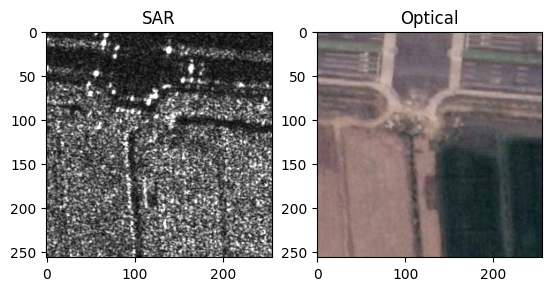

In [9]:
sar, opt = next(iter(loader))
plt.subplot(1, 2, 1); plt.imshow((sar[0].permute(1,2,0)*0.5+0.5).cpu()); plt.title('SAR')
plt.subplot(1, 2, 2); plt.imshow((opt[0].permute(1,2,0)*0.5+0.5).cpu()); plt.title('Optical')


In [10]:
gen.eval()  # disables BatchNorm/Dropout behavior


Pix2Pix(
  (gen): UnetGenerator(
    (encoder): UnetEncoder(
      (enc1): DownsamplingBlock(
        (conv_block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (enc2): DownsamplingBlock(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (enc3): DownsamplingBlock(
        (conv_block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (enc4): DownsamplingBlock(
        (conv_block): Sequential(
          (0): Conv2d

In [11]:
from tqdm import tqdm

n_epochs = 10  # adjust as needed

for epoch in range(n_epochs):
    gen.train()
    running_loss = 0.0

    for sar, opt in tqdm(loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        sar, opt = sar.to(device), opt.to(device)

        optimizer.zero_grad()
        pred = gen(sar)           # forward pass
        loss = criterion(pred, opt)  # L1 loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Avg L1 Loss: {running_loss / len(loader):.4f}")

print("✅ Fine-tuning complete")


Epoch 1/10:   0%|          | 26/9998 [00:47<5:03:43,  1.83s/it]


KeyboardInterrupt: 